# Modeling and Simulation in Python

Case Study: Predicting salmon returns

This case study is based on a ModSim student project by Josh Deng and Erika Lu.

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Can we predict salmon populations?

Each year the [U.S. Atlantic Salmon Assessment Committee](https://www.nefsc.noaa.gov/USASAC/Reports/USASAC2018-Report-30-2017-Activities.pdf) reports estimates of salmon populations in oceans and rivers in the northeastern United States.  The reports are useful for monitoring changes in these populations, but they generally do not include predictions.

The goal of this case study is to model year-to-year changes in population, evaluate how predictable these changes are, and estimate the probability that a particular population will increase or decrease in the next 10 years.

As an example, I'll use data from page 18 of the 2017 report, which provides population estimates for the Narraguagus and Sheepscot Rivers in Maine.

![USASAC_Report_2017_Page18](data/USASAC_Report_2017_Page18.png)

At the end of this notebook, I make some suggestions for extracting data from a PDF document automatically, but for this example I will keep it simple and type it in.

Here are the population estimates for the Narraguagus River:

In [2]:
pops = [2749, 2845, 4247, 1843, 2562, 1774, 1201, 1284, 1287, 2339, 1177, 962, 1176, 2149, 1404, 969, 1237, 1615, 1201];

To get this data into a Pandas Series, I'll also make a range of years to use as an index.

In [3]:
years = range(1997, 2016)

range(1997, 2016)

And here's the series.

In [4]:
pop_series = TimeSeries(pops, index=years, dtype=float)

,values
1997,2749.0
1998,2845.0
1999,4247.0
2000,1843.0
2001,2562.0
2002,1774.0
2003,1201.0
2004,1284.0
2005,1287.0
2006,2339.0


Here's what it looks like:

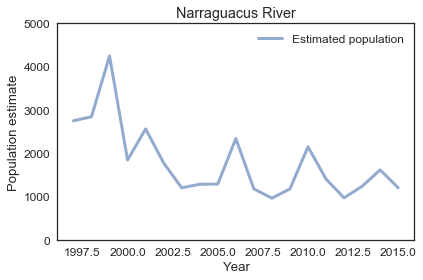

In [5]:
def plot_population(series):
    plot(series, label='Estimated population')
    decorate(xlabel='Year', 
             ylabel='Population estimate', 
             title='Narraguacus River',
             ylim=[0, 5000])
    
plot_population(pop_series)

## Modeling changes

To see how the population changes from year-to-year, I'll use `diff` to compute the absolute difference between each year and the next.

`shift` adjusts the result so each change aligns with the year it happened.

In [6]:
abs_diffs = np.ediff1d(pop_series, np.nan)

array([   96.,  1402., -2404.,   719.,  -788.,  -573.,    83.,     3.,
        1052., -1162.,  -215.,   214.,   973.,  -745.,  -435.,   268.,
         378.,  -414.,    nan])

We can compute relative differences by dividing by the original series elementwise.

In [7]:
rel_diffs = abs_diffs / pop_series

1997    0.034922
1998    0.492794
1999   -0.566047
2000    0.390125
2001   -0.307572
2002   -0.322999
2003    0.069109
2004    0.002336
2005    0.817405
2006   -0.496794
2007   -0.182668
2008    0.222453
2009    0.827381
2010   -0.346673
2011   -0.309829
2012    0.276574
2013    0.305578
2014   -0.256347
2015         NaN
dtype: float64

Or we can use the `modsim` function `compute_rel_diff`:

In [8]:
rel_diffs = compute_rel_diff(pop_series)

These relative differences are observed annual net growth rates.  So let's drop the `NaN` and save them.

In [9]:
rates = rel_diffs.dropna()

A simple way to model this system is to draw a random value from this series of observed rates each year.  We can use the NumPy function `choice` to make a random choice from a series.

In [10]:
np.random.choice(rates)

## Simulation

Now we can simulate the system by drawing random growth rates from the series of observed rates.

I'll start the simulation in 2015.

In [11]:
t_0 = 2015
p_0 = pop_series[t_0]

Create a `System` object with variables `t_0`, `p_0`, `rates`, and `duration=10` years. 

The series of observed rates is one big parameter of the model.

In [12]:
system = System(t_0=t_0,
                p_0=p_0,
                duration=10,
                rates=rates)

Write an update functon that takes as parameters `pop`, `t`, and `system`.
It should choose a random growth rate, compute the change in population, and return the new population.

In [13]:
# Solution goes here

Test your update function and run it a few times

In [14]:
update_func1(p_0, t_0, system)

Here's a version of `run_simulation` that stores the results in a `TimeSeries` and returns it.

In [15]:
def run_simulation(system, update_func):
    """Simulate a queueing system.
    
    system: System object
    update_func: function object
    """
    t_0 = system.t_0
    t_end = t_0 + system.duration
    
    results = TimeSeries()
    results[t_0] = system.p_0
    
    for t in linrange(t_0, t_end):
        results[t+1] = update_func(results[t], t, system)

    return results

Use `run_simulation` to run generate a prediction for the next 10 years.

The plot your prediction along with the original data.  Your prediction should pick up where the data leave off.

In [16]:
# Solution goes here

To get a sense of how much the results vary, we can run the model several times and plot all of the results.

In [17]:
def plot_many_simulations(system, update_func, iters):
    """Runs simulations and plots the results.
    
    system: System object
    update_func: function object
    iters: number of simulations to run
    """
    for i in range(iters):
        results = run_simulation(system, update_func)
        plot(results, color='gray', linewidth=5, alpha=0.1)

The plot option `alpha=0.1` makes the lines semi-transparent, so they are darker where they overlap.

Run `plot_many_simulations` with your update function and `iters=30`.  Also plot the original data.

In [18]:
# Solution goes here

The results are highly variable: according to this model, the population might continue to decline over the next 10 years, or it might recover and grow rapidly!

It's hard to say how seriously we should take this model.  There are many factors that influence salmon populations that are not included in the model.  For example, if the population starts to grow quickly, it might be limited by resource limits, predators, or fishing.  If the population starts to fall, humans might restrict fishing and stock the river with farmed fish.

So these results should probably not be considered useful predictions.  However, there might be something useful we can do, which is to estimate the probability that the population will increase or decrease in the next 10 years.  

## Distribution of net changes

To describe the distribution of net changes, write a function called `run_many_simulations` that runs many simulations, saves the final populations in a `ModSimSeries`, and returns the `ModSimSeries`.


In [19]:
def run_many_simulations(system, update_func, iters):
    """Runs simulations and report final populations.
    
    system: System object
    update_func: function object
    iters: number of simulations to run
    
    returns: series of final populations
    """
    # FILL THIS IN

In [20]:
# Solution goes here

Test your function by running it with `iters=5`.

In [21]:
run_many_simulations(system, update_func1, 5)

Now we can run 1000 simulations and describe the distribution of the results.

In [22]:
last_pops = run_many_simulations(system, update_func1, 1000)
last_pops.describe()

If we substract off the initial population, we get the distribution of changes.

In [23]:
net_changes = last_pops - p_0
net_changes.describe()

The median is negative, which indicates that the population decreases more often than it increases.

We can be more specific by counting the number of runs where `net_changes` is positive.

In [24]:
np.sum(net_changes > 0)

Or we can use `mean` to compute the fraction of runs where `net_changes` is positive.

In [25]:
np.mean(net_changes > 0)

And here's the fraction where it's negative.

In [26]:
np.mean(net_changes < 0)

So, based on observed past changes, this model predicts that the population is more likely to decrease than increase over the next 10 years, by about 2:1.

## A refined model

There are a few ways we could improve the model.

1.  It looks like there might be cyclic behavior in the past data, with a period of 4-5 years.  We could extend the model to include this effect.

2.  Older data might not be as relevant for prediction as newer data, so we could give more weight to newer data.

The second option is easier to implement, so let's try it.

I'll use `linspace` to create an array of "weights" for the observed rates.  The probability that I choose each rate will be proportional to these weights.

The weights have to add up to 1, so I divide through by the total.

In [27]:
weights = linspace(0, 1, len(rates))
weights /= sum(weights)
plot(weights)
decorate(xlabel='Index into the rates array',
         ylabel='Weight')

I'll add the weights to the `System` object, since they are parameters of the model.

In [28]:
system.weights = weights

We can pass these weights as a parameter to `np.random.choice` (see the [documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html))

In [29]:
np.random.choice(system.rates, p=system.weights)

Write an update function that takes the weights into account.

In [30]:
# Solution goes here

Use `plot_many_simulations` to plot the results.

In [31]:
# Solution goes here

Use `run_many_simulations` to collect the results and `describe` to summarize the distribution of net changes.

In [32]:
# Solution goes here

Does the refined model have much effect on the probability of population decline?

In [33]:
# Solution goes here

## Extracting data from a PDF document

The following section uses PyPDF2 to get data from a PDF document.  It uses features we have not seen yet, so don't worry if it doesn't all make sense.

The PyPDF2 package provides functions to read PDF documents and get the data.

If you don't already have it installed, and you are using Anaconda, you can install it by running the following command in a Terminal or Git Bash:

```
conda install -c conda-forge pypdf2
```

In [34]:
import PyPDF2

The 2017 report is in the data directory.

In [35]:
pdfFileObj = open('data/USASAC2018-Report-30-2017-Activities-Page11.pdf', 'rb')

The `PdfFileReader` object knows how to read PDF documents.

In [36]:
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

This file contains only one page.

In [37]:
pdfReader.numPages

`getPage` selects the only page in the document.

In [38]:
page = pdfReader.getPage(0)
page.extractText()

The following function iterates through the lines on the page, removes whitespace, and ignores lines that contain only whitespace.

In [39]:
def iter_page(page):
    for item in page.extractText().splitlines():
        item = item.strip()
        if item:
            yield item

The following function gets the next `n` pages from the page.

In [40]:
def next_n(iterable, n):
    """Get the next n items from an iterable."""
    return [next(iterable) for i in range(n)]

We skip the text at the top of the page.

In [41]:
t = iter_page(page)
discard = next_n(t, 8)

The next 7 strings are the column headings of the table.

In [42]:
columns = next_n(t, 7)

Create an empty `Dataframe` with the column headings.

In [43]:
df = pd.DataFrame(columns=columns)
df

Get the next 19 lines of the table.

In [44]:
for i in range(19):
    year = int(next(t))
    data = next_n(t, 7)
    df.loc[year] = data

The last line in the table gets messed up, so I'll do that one by hand.

In [45]:
df.loc[2017] = ['363', '663', '13', '2', '1041', '806', '235'] 

Here's the result.

In [46]:
df

In general, reading tables from PDF documents is fragile and error-prone.  Sometimes it is easier to just type it in.